# Validating Steane Encoding

In [80]:
from qiskit import QuantumCircuit
import numpy as np
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
from qiskit.visualization import plot_histogram 
import typing
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

from qiskit_aer import Aer
from qiskit import transpile
from qiskit_aer.primitives import Sampler
from qiskit.primitives.backend_sampler import BackendSampler
from qiskit.quantum_info import Statevector
from qiskit.circuit import Instruction
from matplotlib import pyplot as plt
from qiskit.quantum_info import state_fidelity

First, we will validate the Steane encoding with the |0> state. There are two encoding schemes I use--the 7 qubit encoding scheme and the 8 qubit encoding scheme.


In [81]:


amp_0 = 1
amp_1 = 0

print(Statevector([amp_0, amp_1]))


Statevector([1.+0.j, 0.+0.j],
            dims=(2,))


In [82]:
def steane_enc_8(amp_0: float, amp_1: float, is_ideal: bool):


    if is_ideal == True:
        steane_enc_block = QuantumCircuit(8, 8, name="steane_block")
    else:
        steane_enc_block = QuantumCircuit(8, name="steane_block_noise")


    steane_enc_block.h(0)
    steane_enc_block.h(4)
    steane_enc_block.h(6)

    #steane_enc_block.initialize([amp_0, amp_1], 6)
    steane_enc_block.initialize([amp_0, amp_1], 6)

    steane_enc_block.barrier()

    steane_enc_block.cx(0, 1)
    steane_enc_block.cx(4, 5)
    steane_enc_block.cx(6, 3)

    steane_enc_block.cx(4,2)
    steane_enc_block.cx(6,5)

    steane_enc_block.cx(0,3)
    steane_enc_block.cx(4,1)

    steane_enc_block.cx(3,2)

    steane_enc_block.cx(1,7)
    steane_enc_block.cx(3,7)
    steane_enc_block.cx(5,7)

    steane_enc_block.barrier()

    for i in range(0, 8):
        steane_enc_block.h(i)
        #steane_enc_block.measure(i,0)
    steane_enc_block.barrier()
    # steane_enc_block.measure(7,0)


    #print(steane_enc_block)

    return steane_enc_block

In [83]:
def steane_enc_7(amp_0: float, amp_1: float, is_ideal: bool):


    if is_ideal == True:
        steane_enc_block = QuantumCircuit(7, 7, name="steane_block")
    else:
        steane_enc_block = QuantumCircuit(7, name="steane_block_noise")

    for i in range(1,4):
        steane_enc_block.h(i)
    
    steane_enc_block.h(6)
    steane_enc_block.initialize([amp_0, amp_1], 6)

    steane_enc_block.barrier()

    steane_enc_block.cx(1,0)
    steane_enc_block.cx(2,4)
    steane_enc_block.cx(6,5)

    steane_enc_block.cx(2,0)
    steane_enc_block.cx(3,5)
    steane_enc_block.cx(6,4)
    steane_enc_block.cx(2,6)
    steane_enc_block.cx(3,4)
    steane_enc_block.cx(1,5)
    steane_enc_block.cx(1,6)
    steane_enc_block.cx(3,0)
    
    steane_enc_block.barrier()

    # switch to measuring in other basis
    for i in range(0, 7):
        steane_enc_block.h(i)

    #print(steane_enc_block)
    return steane_enc_block


steane_enc_7(amp_0, amp_1, True)

In [84]:
def steane_dec_8(steane_dec_block: QuantumCircuit, is_ideal: bool):
    
    for i in range(0, 8):
        steane_dec_block.h(i)
    
    steane_dec_block.barrier()

    steane_dec_block.cx(5,7)
    steane_dec_block.cx(3,7)
    steane_dec_block.cx(1,7)

    steane_dec_block.cx(3,2)

    steane_dec_block.cx(4,1)
    steane_dec_block.cx(0,3)

    steane_dec_block.cx(6,5)
    steane_dec_block.cx(4,2)

    steane_dec_block.cx(6, 3)
    steane_dec_block.cx(4, 5)
    steane_dec_block.cx(0, 1)

    steane_dec_block.barrier()

    return steane_dec_block
    

In [85]:
def steane_dec_7(steane_dec_block: QuantumCircuit, is_ideal: bool):


    for i in range(0, 7):
        steane_dec_block.h(i)

    steane_dec_block.barrier()

    steane_dec_block.cx(3,0)
    steane_dec_block.cx(1,6)
    steane_dec_block.cx(1,5)
    steane_dec_block.cx(3,4)
    steane_dec_block.cx(2,6)
    steane_dec_block.cx(6,4)
    steane_dec_block.cx(3,5)
    steane_dec_block.cx(2,0)

    steane_dec_block.cx(6,5)
    steane_dec_block.cx(2,4)
    steane_dec_block.cx(1,0)
    


    steane_dec_block.barrier()


    
    
    # for i in range(0, 7):
    #     steane_dec_block.measure(i,i)
    steane_dec_block.measure(6,0)


    return steane_dec_block



    

In [86]:
# convert to instruction
steane_block_instr = steane_enc_8(amp_0, amp_1, True).to_instruction()

In [87]:

steane_block_instr_7 = steane_enc_7(amp_0, amp_1, True).to_instruction()

In [88]:
steane_block_instr_noise = steane_enc_8(amp_0, amp_1, False).to_instruction()

In [89]:
steane_block_instr_7_noise = steane_enc_7(amp_0, amp_1, False).to_instruction()

In [90]:
# applies h to n qubits 
def create_h_block(num: int, is_ideal: bool):
    if (is_ideal == 1):
        h_block = QuantumCircuit(num, num, name="h_block")
    else:
        h_block = QuantumCircuit(num, name="h_block_noise")

    for i in range(0, num):
        h_block.h(i)

    # convert to instruction
    h_block_instr = h_block.to_instruction()
    return h_block_instr

In [91]:
# applies cz to n qubits
def create_cz_block(num: int, is_ideal: bool):
    if (is_ideal == 1):
        cz_block = QuantumCircuit(num*2, num*2, name="cz_block")
    else:
        cz_block = QuantumCircuit(num*2, name="cz_block_noise")
    
    for i in range(0, num):
        cz_block.cz(i, i + num)
        print(num)

    # convert to instruction
    cz_block_instr = cz_block.to_instruction()
    return cz_block_instr

In [92]:
# applies identity to 7 qubits
def create_id_block(num: int, is_ideal: bool):

    if (is_ideal == 1):
        id_block = QuantumCircuit(num, num, name = "id_block")
    else:
        id_block = QuantumCircuit(num, name = "id_block")
    

    for i in range(0, num):
        id_block.id(i)

    id_block_instr = id_block.to_instruction()
    return id_block_instr

In [93]:
# applies x to 7 qubits
def create_x_block(num: int, is_ideal: bool):
    if (is_ideal == 1):
        x_block = QuantumCircuit(num, num, name = "x_block")
    else:
        x_block = QuantumCircuit(num, name = "x_block")
    

    for i in range(0, num):
        x_block.x(i)

    x_block_instr = x_block.to_instruction()
    return x_block_instr

In [94]:
def prepare_state(qc_prep: QuantumCircuit, encode_block: Instruction, log_block: Instruction, num: int, is_ideal: bool):

    if (is_ideal == 1):
        qc_prep.append(create_id_block(num, is_ideal), range(0,num), range(0,num))
        qc_prep.append(encode_block, range(0,num), range(0,num))
        qc_prep.append(create_id_block(num, is_ideal), range(0,num), range(0,num))
        qc_prep.append(log_block,range(0,num), range(0,num))
        qc_prep.draw('mpl')
    else:
        qc_prep.append(create_id_block(num, is_ideal), range(0,num))
        qc_prep.append(encode_block, range(0,num))
        qc_prep.append(create_id_block(num, is_ideal), range(0,num))
        qc_prep.append(log_block,range(0,num))
        qc_prep.draw('mpl')



In [223]:


qc_arr_meas = []


def preparation_results(qc_arr: list, num: int, is_ideal: bool, is_counts:bool, encoding: Instruction, noise_model: NoiseModel):



    # if is_ideal == True:
    qca = QuantumCircuit(num,num)
    qcb = QuantumCircuit(num,num)
    qcc = QuantumCircuit(num,num)
    # else:
    #     qca = QuantumCircuit(num)
    #     qcb = QuantumCircuit(num)
    #     qcc = QuantumCircuit(num)




    qc_arr = [qca, qcb, qcc]



    state_arr = []
    counts_arr = []

    

    
    for i in range(0,3): 

        prepare_state(qc_arr[i], encoding, create_id_block(num, is_ideal), num, is_ideal)

        if (is_counts == True):
            for j in range(0,7):
                qc_arr[i].measure(j,j)


        if is_counts == False:
            if is_ideal == True:
                simulator = Aer.get_backend('statevector_simulator')
                steane_t = transpile(qc_arr[i], simulator)
                job = simulator.run(steane_t, shots = 1000)
                result = job.result()
                # counts = result.get_counts()
                state = result.get_statevector()
                state_arr.append(state)
                # counts_arr.append(counts)
            else:
                qc_arr[i].save_statevector(label='state_post', pershot=True, conditional=True)
                for j in range(0,7):
                    qc_arr[i].measure(j,j)
                backend = AerSimulator(noise_model=noise_model)
                transpiled = transpile(qc_arr[i], backend)
                job = backend.run(transpiled, shots=1000)
                result = job.result()
                # state = result.get_statevector()
                # state_arr.append(state)
                state = result.data()['state_post']
                #print(state)
                for shot in state['0x0']:
                    state_arr.append(shot.data)
        else:
            backend = AerSimulator(noise_model=noise_model)
            transpiled = transpile(qc_arr[i], backend)
            job = backend.run(transpiled, shots = 1000)
            result = job.result()
            counts_n = result.get_counts()
            counts_arr.append(counts_n)

    return [qc_arr, state_arr, counts_arr]


        
    




In [150]:
no_noise = NoiseModel()

In [97]:
[qc_arr_meas, state_arr_meas, counts_arr_meas] = preparation_results(qc_arr_meas, 8, True, True, steane_block_instr, no_noise)



c:\Users\diyan\anaconda3\lib\site-packages\qiskit\circuit\quantumcircuit.py:3263: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


In [98]:


qc_arr_meas_7 = []

[qc_arr_meas_7, state_arr_meas_7, counts_arr_meas_7] = preparation_results(qc_arr_meas_7, 7, True, True, steane_block_instr_7, no_noise)


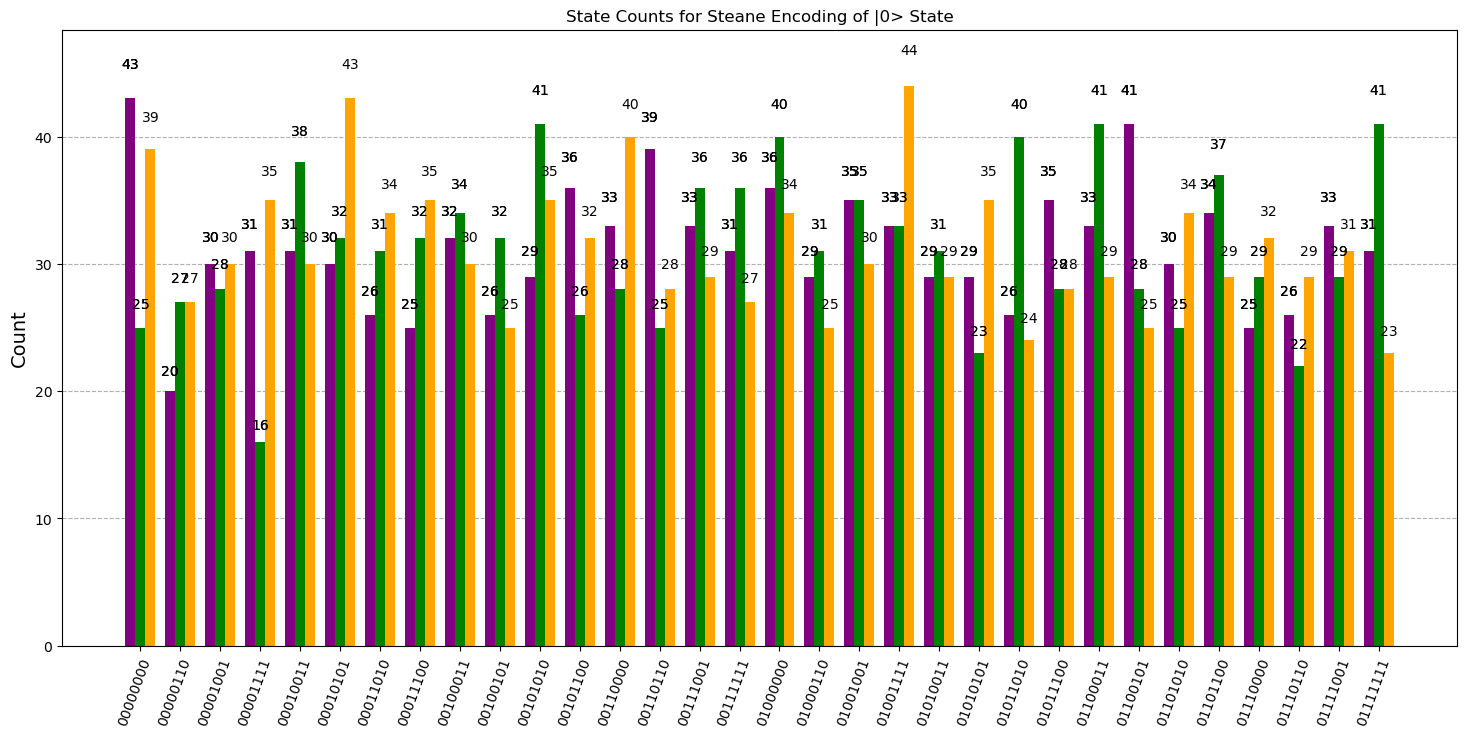

In [99]:
plot_histogram(counts_arr_meas, 
               figsize = (18, 8), 
               title = "State Counts for Steane Encoding of |0> State",
               color = ["purple", "green", "orange"])

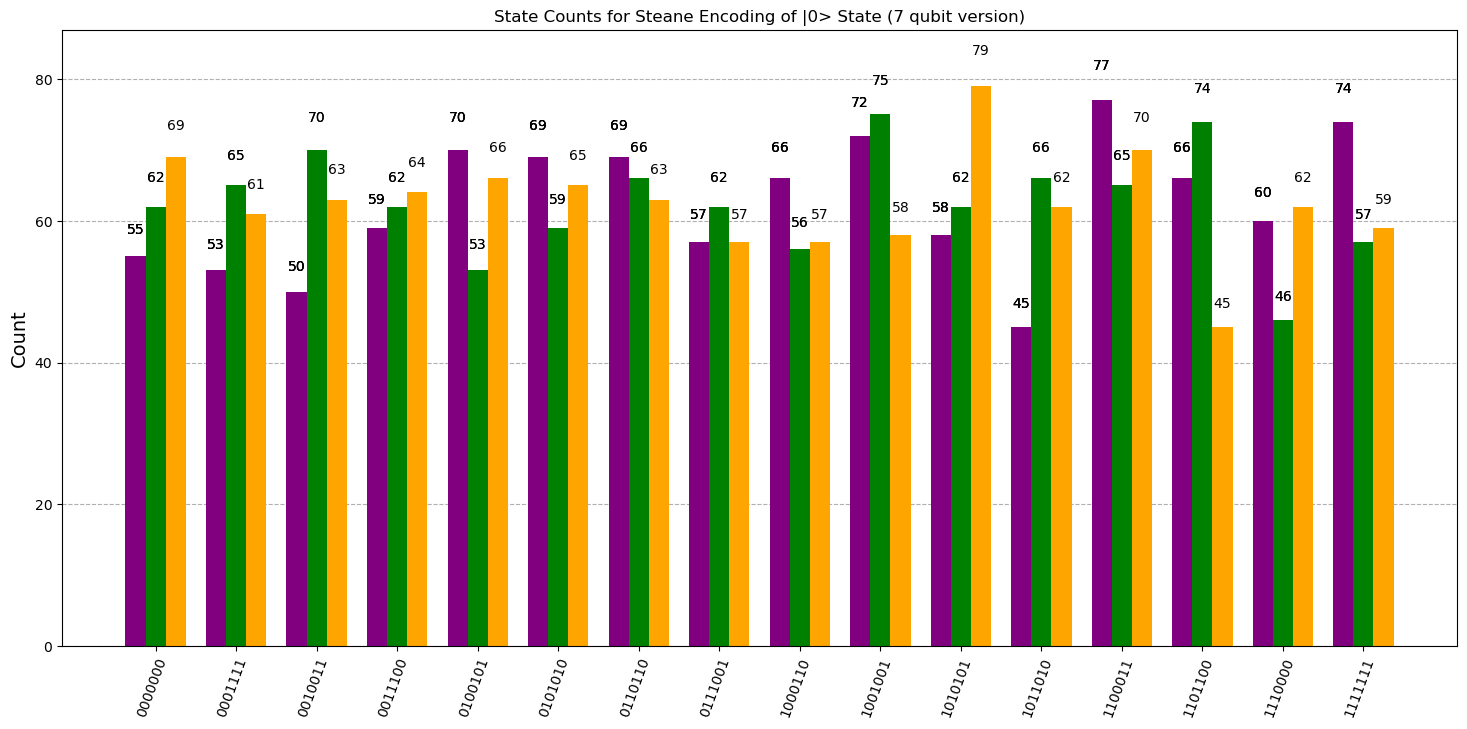

In [100]:
plot_histogram(counts_arr_meas_7, 
               figsize = (18, 8), 
               title = "State Counts for Steane Encoding of |0> State (7 qubit version)",
               color = ["purple", "green", "orange"])

In [101]:
def raw_v_enc(raw_sv: Statevector, state_arr_sv: list):
    fid_arr = []
    err_arr = []


    for z in state_arr_sv[0]:
        state = np.array([np.sqrt(1 - abs(z)**2), z], dtype=np.complex128)
        svi = Statevector(state)
        fid = state_fidelity(raw_sv, svi)
        #print(fid)
        err = 1 - fid
        fid_arr.append(fid)
        err_arr.append(err)




    # for svi in state_arr_sv:
    #     # svi is a multi-qubit Statevector
    #     for q in range(0,7):
    #         if q != 7:
    #             reduced = partial_trace(svi, q)
        
    #     # 'reduced' is now a 1-qubit DensityMatrix

    #     fid = state_fidelity(raw_sv, reduced)
    #     err = 1 - fid

    #     fid_arr.append(fid)
    #     err_arr.append(err)

    # print([np.sqrt(1 - abs(z)**2), z])

    mean_err = np.mean(err_arr)
    mean_fid = np.mean(fid_arr)

    # print(err_arr)
    # print(fid_arr)

    return [err_arr, fid_arr, mean_err, mean_fid]


    
    

In [102]:

qc_arr_sv = []

[qc_arr_sv, state_arr_sv, counts_arr_sv] = preparation_results(qc_arr_sv, 8, True, False, steane_block_instr, no_noise)


qc_arr_7 = []


[qc_arr_7, state_arr_sv_7, counts_arr_sv_7] = preparation_results(qc_arr_7, 7, True, False, steane_block_instr_7, no_noise)




In [104]:
# steane_dec_qc_7 = steane_dec_7(qc_arr_7[0], True)
# steane_dec_qc_8 = steane_dec_8(qc_arr_sv[0], True)


In [105]:
# print(steane_dec_7(qc_arr_7[0], True))

In [106]:


# backend = Aer.get_backend('qasm_simulator')
# transpiled = transpile(steane_dec_qc_7, backend)
# job = backend.run(transpiled, shots = 1000)
# result = job.result()
# counts = result.get_counts()

# print(counts)

# plot_histogram(counts)

In [107]:
from qiskit.quantum_info import DensityMatrix

In [108]:
# sv = Statevector([amp_0, amp_1])
# print(sv)

# def logical_vs_raw_fidelity(raw_sv: Statevector, decoded: QuantumCircuit, logical_index=0):
#     # Apply decoding
#     #print(decoded.num_qubits)
    
#     # Trace out all but logical qubit
#     qubits_to_trace = [i for i in range(decoded.num_qubits) if i != logical_index]
#     print(qubits_to_trace)
#     reduced = partial_trace(DensityMatrix.from_instruction(decoded.to_instruction()), qubits_to_trace)

#     print(reduced)

#     # Compare fidelity with raw ideal state
#     fid = state_fidelity(raw_sv, reduced)
#     err = 1 - fid

#     return err, fid

In [109]:
# logical_vs_raw_fidelity(sv, steane_dec_qc_7)
# ""


In [110]:
# sv = Statevector([amp_0, amp_1])
# print(sv)

# for z in state:
#     if z != np.complex128(0):
#         vec = np.array([z, 0], dtype=complex)
#         print(vec)
#         vec = vec / np.linalg.norm(vec)
#         svi = Statevector(vec)
#         break

# print(svi)
# fid = state_fidelity(sv, svi)
# print(fid)
# err = 1 - fid

In [111]:
# import builtins

# %load_ext autoreload
# %autoreload 2

# import steane_decoder

In [112]:

# syndrome = list(map(int, input_str.split()))
# print(syndrome)
# print(len(syndrome))

In [113]:
# steane_decoder.main()



In [114]:
print(counts_arr_meas)

[{'00101100': 36, '01100101': 41, '01111001': 33, '00100101': 26, '01110110': 26, '01001001': 35, '00110000': 33, '00011010': 26, '01000110': 29, '00000000': 43, '01100011': 33, '00000110': 20, '01000000': 36, '00010011': 31, '00101010': 29, '00110110': 39, '01110000': 25, '00100011': 32, '01101010': 30, '00011100': 25, '01011010': 26, '00001001': 30, '00111111': 31, '01010101': 29, '00111001': 33, '01001111': 33, '01010011': 29, '00010101': 30, '01101100': 34, '01111111': 31, '01011100': 35, '00001111': 31}, {'00101010': 41, '00110110': 25, '01111001': 29, '00010011': 38, '00011010': 31, '01000110': 31, '00000000': 25, '00100101': 32, '01110110': 22, '00010101': 32, '00110000': 28, '01010101': 23, '01011100': 28, '00111001': 36, '00101100': 26, '01100101': 28, '01011010': 40, '01001001': 35, '00011100': 32, '01101010': 25, '00001001': 28, '00111111': 36, '00000110': 27, '01000000': 40, '00100011': 34, '01110000': 29, '01101100': 37, '01111111': 41, '01010011': 31, '00001111': 16, '010

In [115]:


# def run_with_inputs(decoder, inputs):
#     original_input = builtins.input  # Save original input()
#     inputs_iter = iter(inputs)       # Create iterator over your input list

#     def fake_input(prompt=''):
#         val = next(inputs_iter.key)
#         print(f"{prompt}{val}")  # Optional: mimic the prompt+input
#         return val

#     builtins.input = fake_input      # Override input()

#     try:
#         decoder()  # Call the function that uses input()
#     finally:
#         builtins.input = original_input  # Restore input()




# run_with_inputs(steane_decoder.main(), counts_arr_sv)

### Mean Error and Mean Fidelity of Raw vs. Steane Encoded |0>


In [116]:
# Compare ideal raw state to encoded state

sv = Statevector([amp_0, amp_1])
print(sv)
print(state_arr_sv[0])

[err_8_arr, fid_8_arr, err_8_mean, fid_8_mean] = raw_v_enc(sv, state_arr_sv)
[err_7_arr, fid_7_arr, err_7_mean, fid_7_mean]  = raw_v_enc(sv, state_arr_sv_7)

print(err_8_mean)
print(err_7_mean)

Statevector([1.+0.j, 0.+0.j],
            dims=(2,))
Statevector([ 1.25000000e-01-4.5924255e-17j,
             -4.48005088e-18+1.5308085e-17j,
              1.08056541e-33+1.5308085e-17j,
             -4.48005088e-18+1.5308085e-17j,
              1.08056541e-33+1.5308085e-17j,
             -4.48005088e-18+1.5308085e-17j,
              1.25000000e-01-4.5924255e-17j,
             -4.48005088e-18+1.5308085e-17j,
             -4.48005088e-18+1.5308085e-17j,
              1.25000000e-01-4.5924255e-17j,
             -4.48005088e-18+1.5308085e-17j,
              1.08056541e-33+1.5308085e-17j,
             -4.48005088e-18+1.5308085e-17j,
              1.08056541e-33+1.5308085e-17j,
             -4.48005088e-18+1.5308085e-17j,
              1.25000000e-01-4.5924255e-17j,
             -4.48005088e-18+1.5308085e-17j,
              1.08056541e-33+1.5308085e-17j,
             -4.48005088e-18+1.5308085e-17j,
              1.25000000e-01-4.5924255e-17j,
             -4.48005088e-18+1.5308085e-17j,
  

C:\Users\diyan\AppData\Local\Temp\ipykernel_25148\247150886.py:6: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  for z in state_arr_sv[0]:


In [117]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Fidelity Errors Preparing |0> State in the Steane Code')

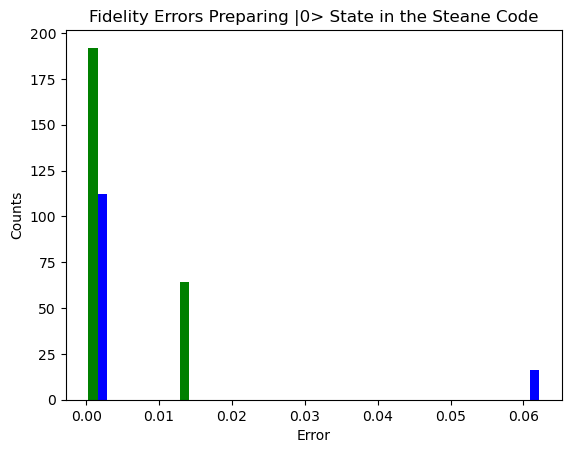

In [118]:

plt.hist([err_8_arr, err_7_arr], bins = 20, color= ['green', 'blue'])
plt.xlabel("Error")
plt.ylabel("Counts")
plt.title("Fidelity Errors Preparing |0> State in the Steane Code")

The mean error rate for 8 qubit encoding scheme is 0.39%, while the mean error rate for 7 qubit encoding is 0.78%

In [119]:
from qiskit.quantum_info import DensityMatrix


In [120]:
# 5% chance of flipping 0 <-> 1
readout_err = ReadoutError([[0.98, 0.02],  # P(measured 0 | actual 0), P(1 | 0)
                            [0.02, 0.98]]) # P(0 | 1), P(1 | 1)

noise_model = NoiseModel()

noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01,1), ['id'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01,1), ['h'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01,2),['cz'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01,2),['cx'])


# we actually don't want readout error because we want to measure the logical qubits that would be
# put into the 21 qubit MSD circuit w/o measuring
# for i in range(0,7):
#     noise_model.add_readout_error(readout_err, [i])

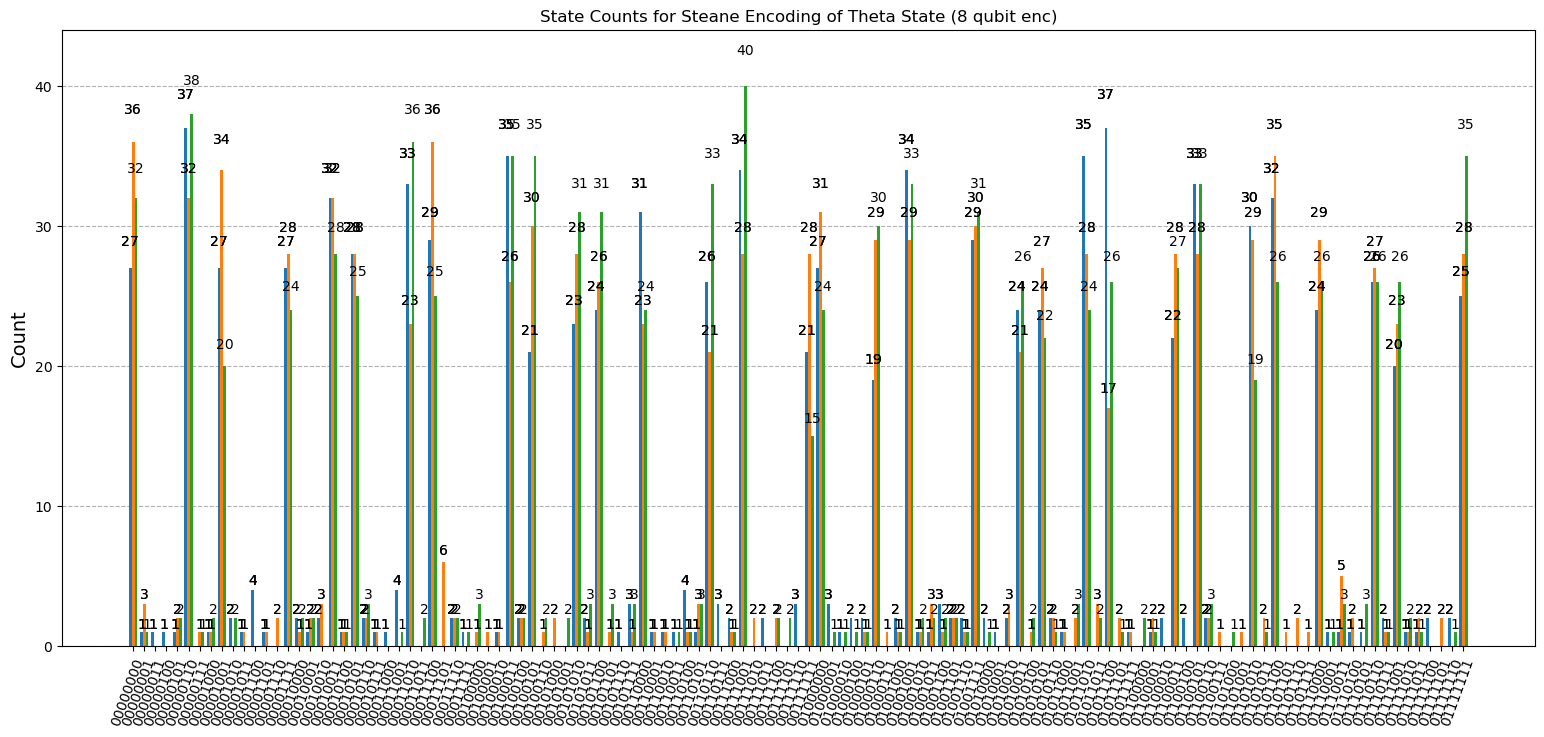

In [121]:


qc_arr_n = []

[qc_arr_n, state_arr_n, counts_arr_n] = preparation_results(qc_arr_n, 8, False, True, steane_block_instr_noise, noise_model)



plot_histogram(counts_arr_n, figsize = (19, 8), title = "State Counts for Steane Encoding of Theta State (8 qubit enc)")




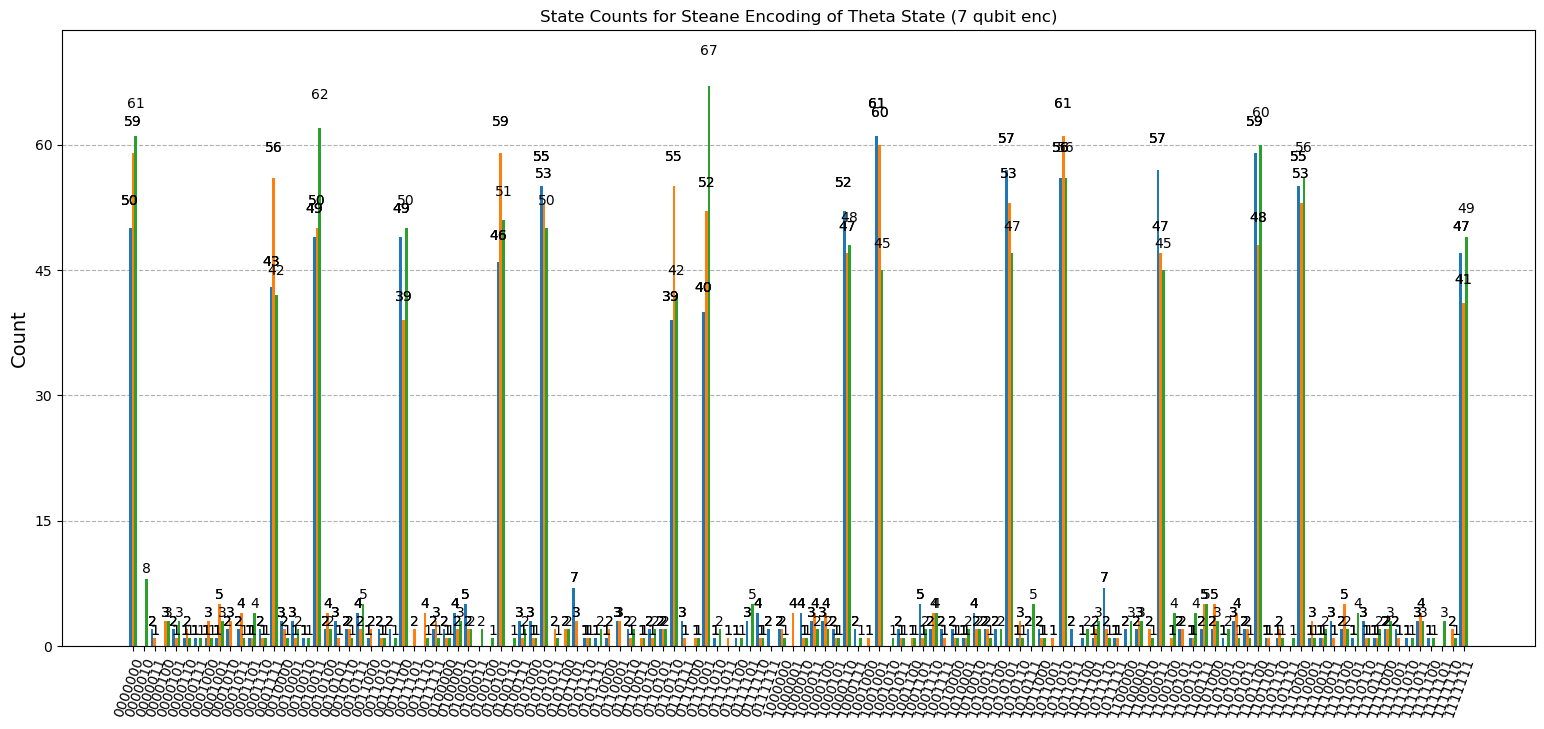

In [122]:


qc_arr_n_7 = []

[qc_arr_n_7, state_arr_n_7, counts_arr_n_7] = preparation_results(qc_arr_n_7, 7, False, True, steane_block_instr_7_noise, noise_model)


plot_histogram(counts_arr_n_7, figsize = (19, 8), title = "State Counts for Steane Encoding of Theta State (7 qubit enc)")

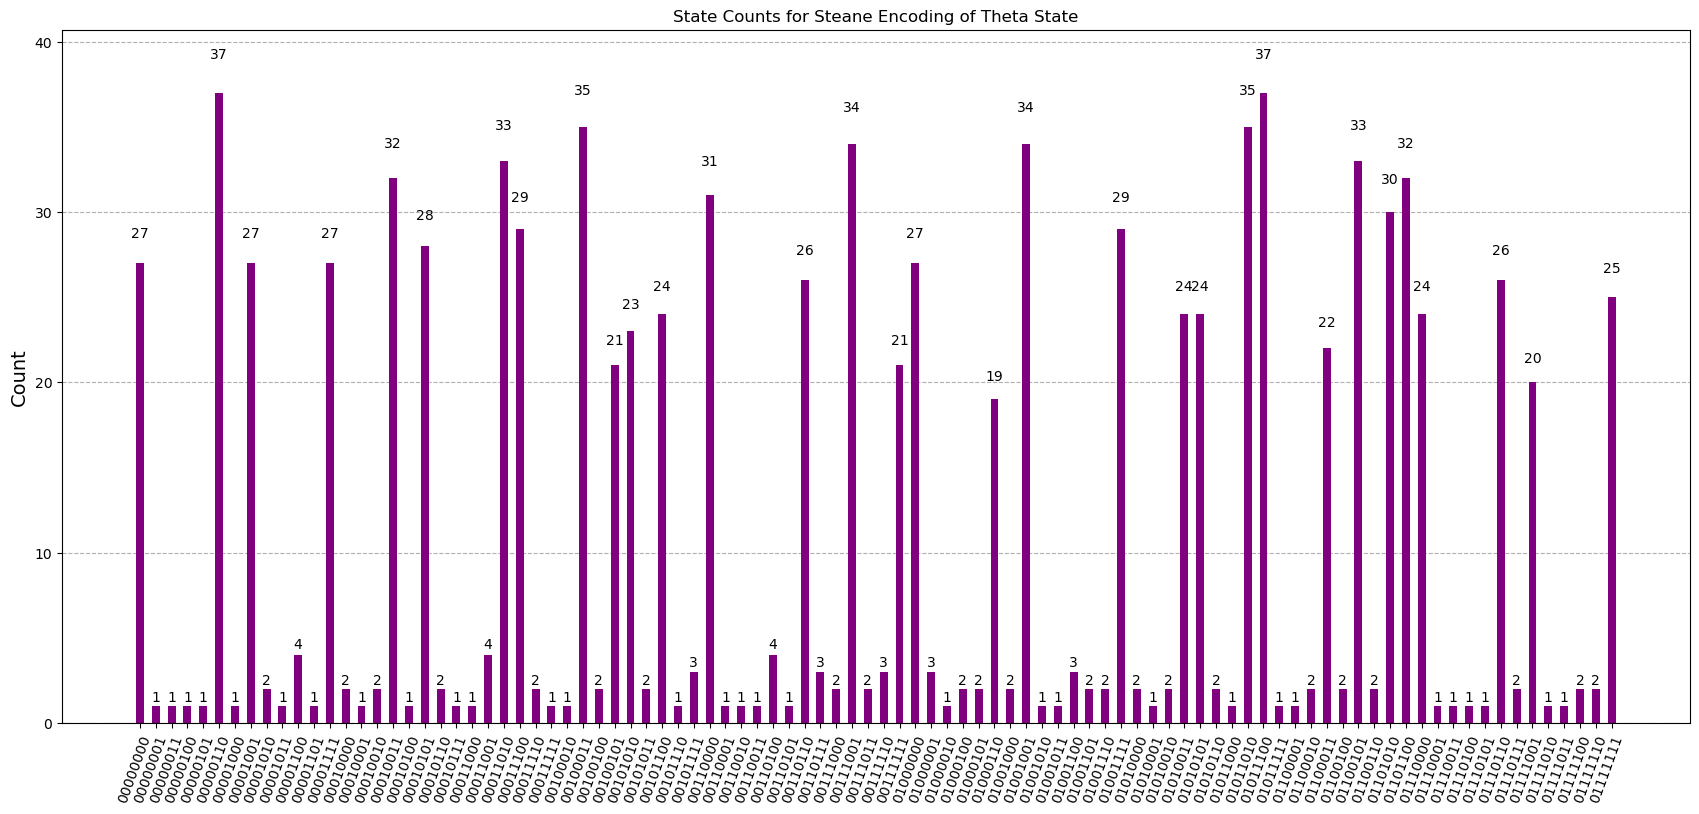

In [123]:
plot_histogram(counts_arr_n[0], 
               figsize = (21, 9), 
               title = "State Counts for Steane Encoding of Theta State",
               color = "purple")


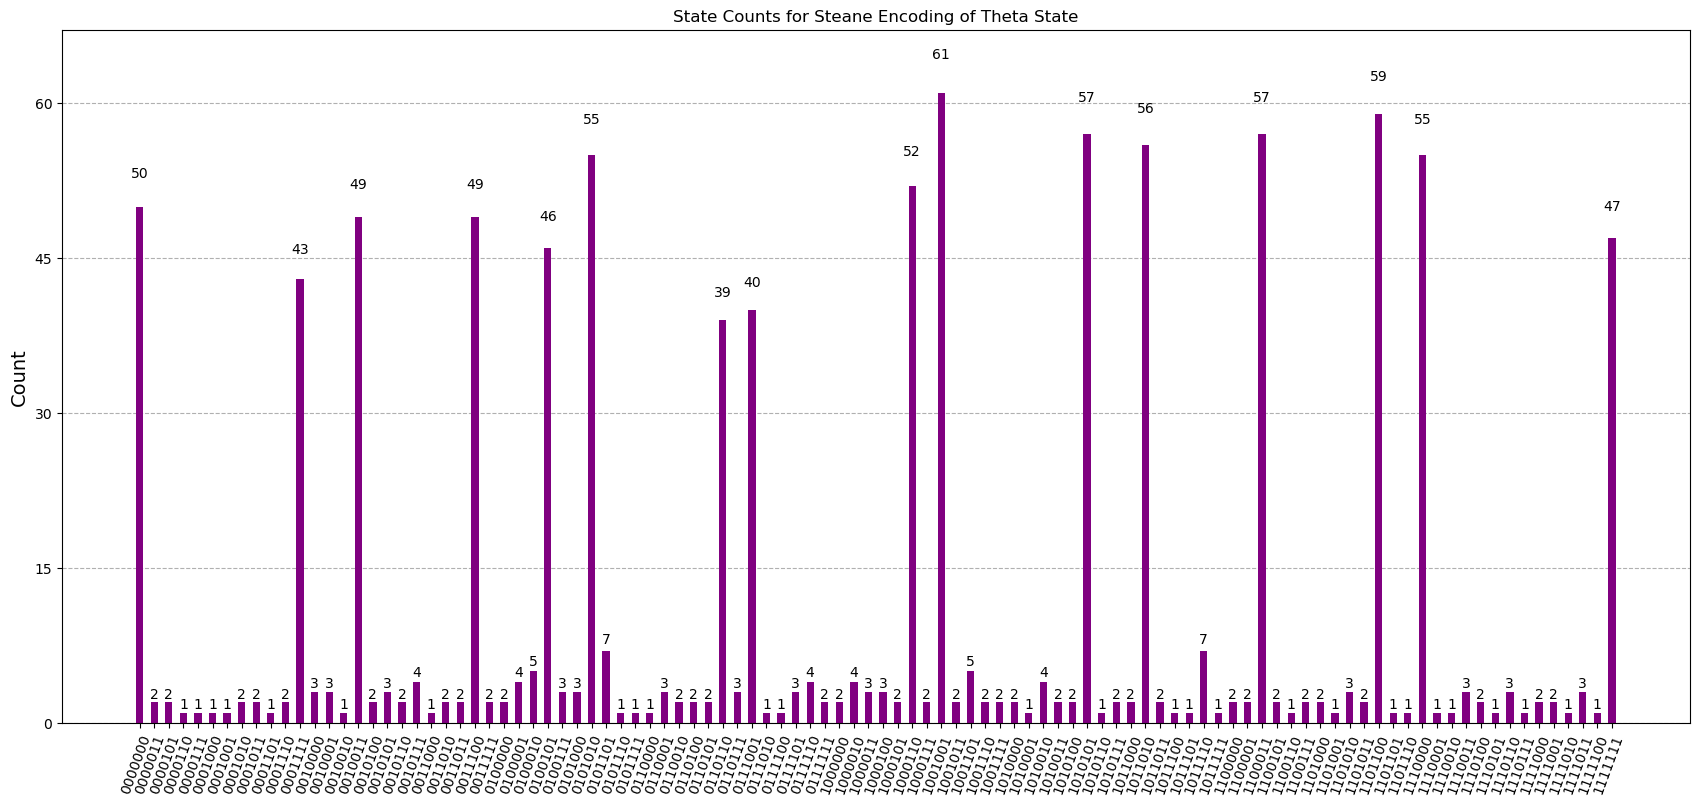

In [124]:
plot_histogram(counts_arr_n_7[0], 
               figsize = (21, 9), 
               title = "State Counts for Steane Encoding of Theta State",
               color = "purple")

In [224]:
qc_arr_8_n_sv = []

[qc_arr_8_n_sv, state_arr_8_n_sv, counts_arr_8_n_sv] = preparation_results(qc_arr_8_n_sv, 
                                                               num = 8, 
                                                               is_ideal = False, 
                                                               is_counts = False, 
                                                               encoding = steane_block_instr_noise, 
                                                               noise_model = noise_model)


qc_arr_7_n_sv = []


[qc_arr_7_n_sv, state_arr_7_n_sv, counts_arr_7_n_sv] = preparation_results(qc_arr_7_n_sv, 
                                                                  num = 7, 
                                                                  is_ideal = False, 
                                                                  is_counts = False, 
                                                                  encoding = steane_block_instr_7_noise, 
                                                                  noise_model = noise_model)




In [225]:

# Statevector(state_arr_8_n_sv[0])


In [226]:
#Statevector(state_arr_8_n_sv[0])
# print(state_arr_8_n_sv[0])

In [227]:
#print(state_arr_sv)

In [228]:
fid_8_arr_sv = []
for i in range(0,3):
    sv_ideal = Statevector(state_arr_sv[i])
    sv_noise = Statevector(state_arr_8_n_sv[i])
    fid = state_fidelity(sv_ideal, sv_noise)
    fid_8_arr_sv.append(fid)

print(fid_8_arr_sv)
print(np.mean(fid_8_arr_sv))


[1.0000000000000009, 1.0000000000000009, 1.0000000000000009]
1.0000000000000009


dict

In [125]:
from collections import defaultdict
import numpy as np

def fidelity_from_counts(counts_ideal, counts_noisy):
    # Normalize to probabilities
    total_ideal = sum(counts_ideal.values())
    total_noisy = sum(counts_noisy.values())

    p = defaultdict(float, {k: v / total_ideal for k, v in counts_ideal.items()})
    q = defaultdict(float, {k: v / total_noisy for k, v in counts_noisy.items()})

    # Get all keys
    all_keys = set(p) | set(q)

    # Bhattacharyya coefficient
    bc = sum(np.sqrt(p[k] * q[k]) for k in all_keys)
    return bc ** 2  # fidelity minimum bound

## Fidelity of |0>

In [126]:

mean_arr_fid = []
for i in range(0,3):
    ffc = fidelity_from_counts(counts_arr_meas[i], counts_arr_n[i])
    mean_arr_fid.append(ffc)


print(mean_arr_fid)
print(np.mean(mean_arr_fid))



[0.8835824421405388, 0.8861616955581847, 0.8880058759132811]
0.8859166712040015


In [127]:
mean_arr_fid_7 = []
for i in range(0,3):
    ffc = fidelity_from_counts(counts_arr_meas_7[i], counts_arr_n_7[i])
    mean_arr_fid_7.append(ffc)


print(mean_arr_fid_7)
print(np.mean(mean_arr_fid_7))


[0.808276763900937, 0.8276733102007138, 0.8223841884882597]
0.8194447541966369


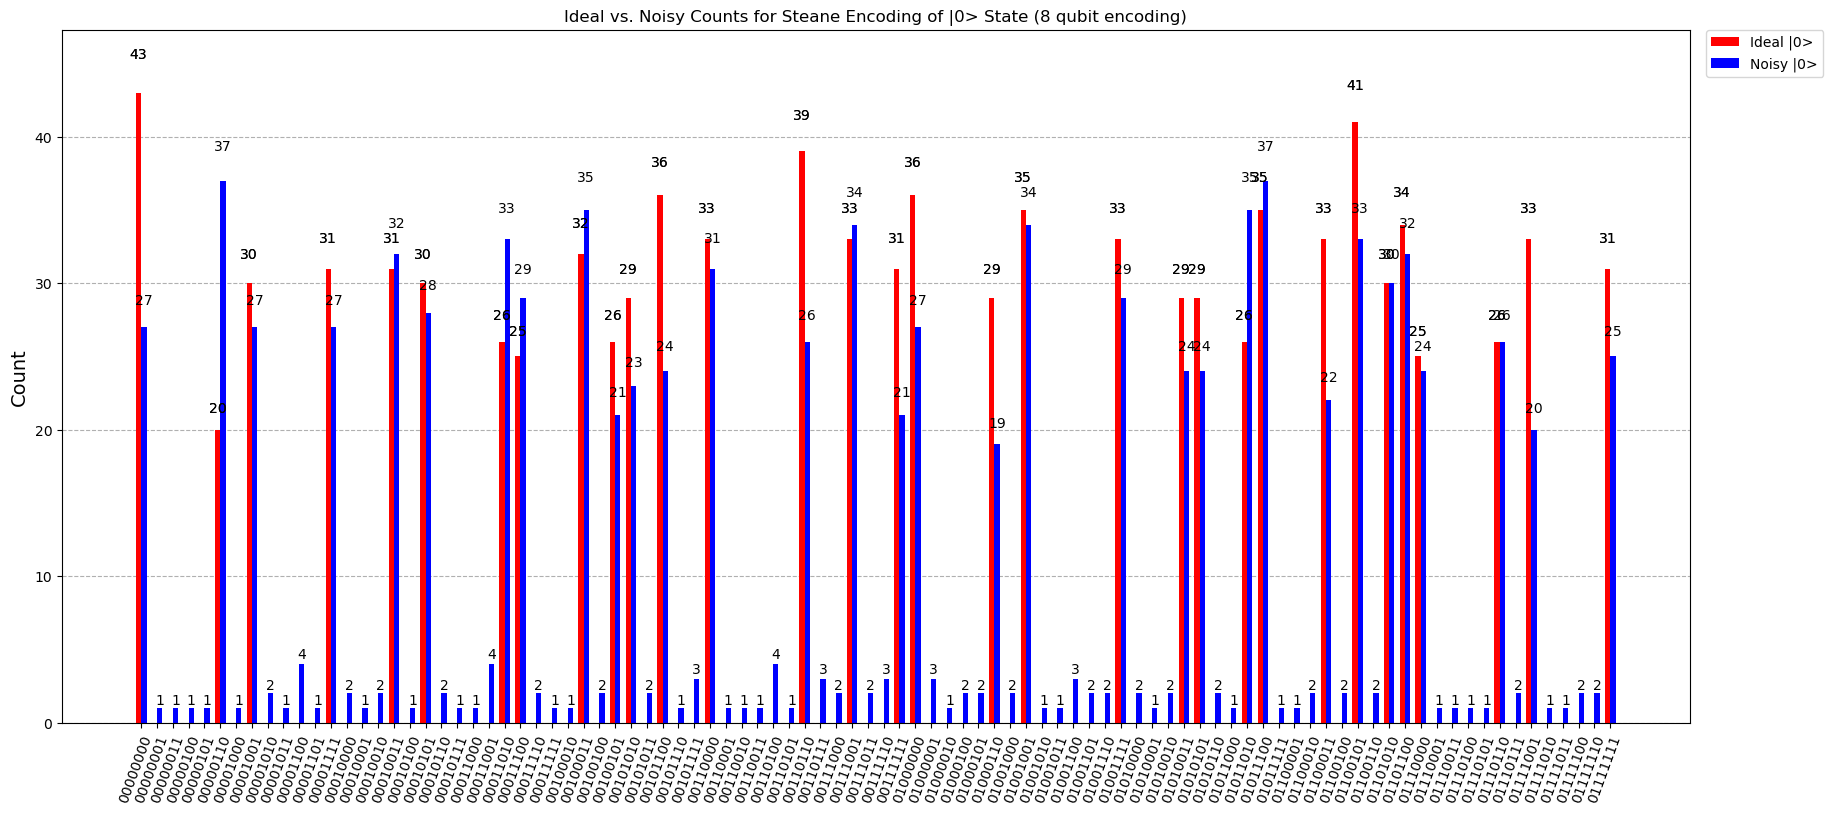

In [128]:
plot_histogram([counts_arr_meas[0], counts_arr_n[0]], 
               figsize = (21, 9), 
               title = "Ideal vs. Noisy Counts for Steane Encoding of |0> State (8 qubit encoding)", 
               bar_labels = True, 
               legend=['Ideal |0>', 'Noisy |0>'],
               color = ["red", "blue"])

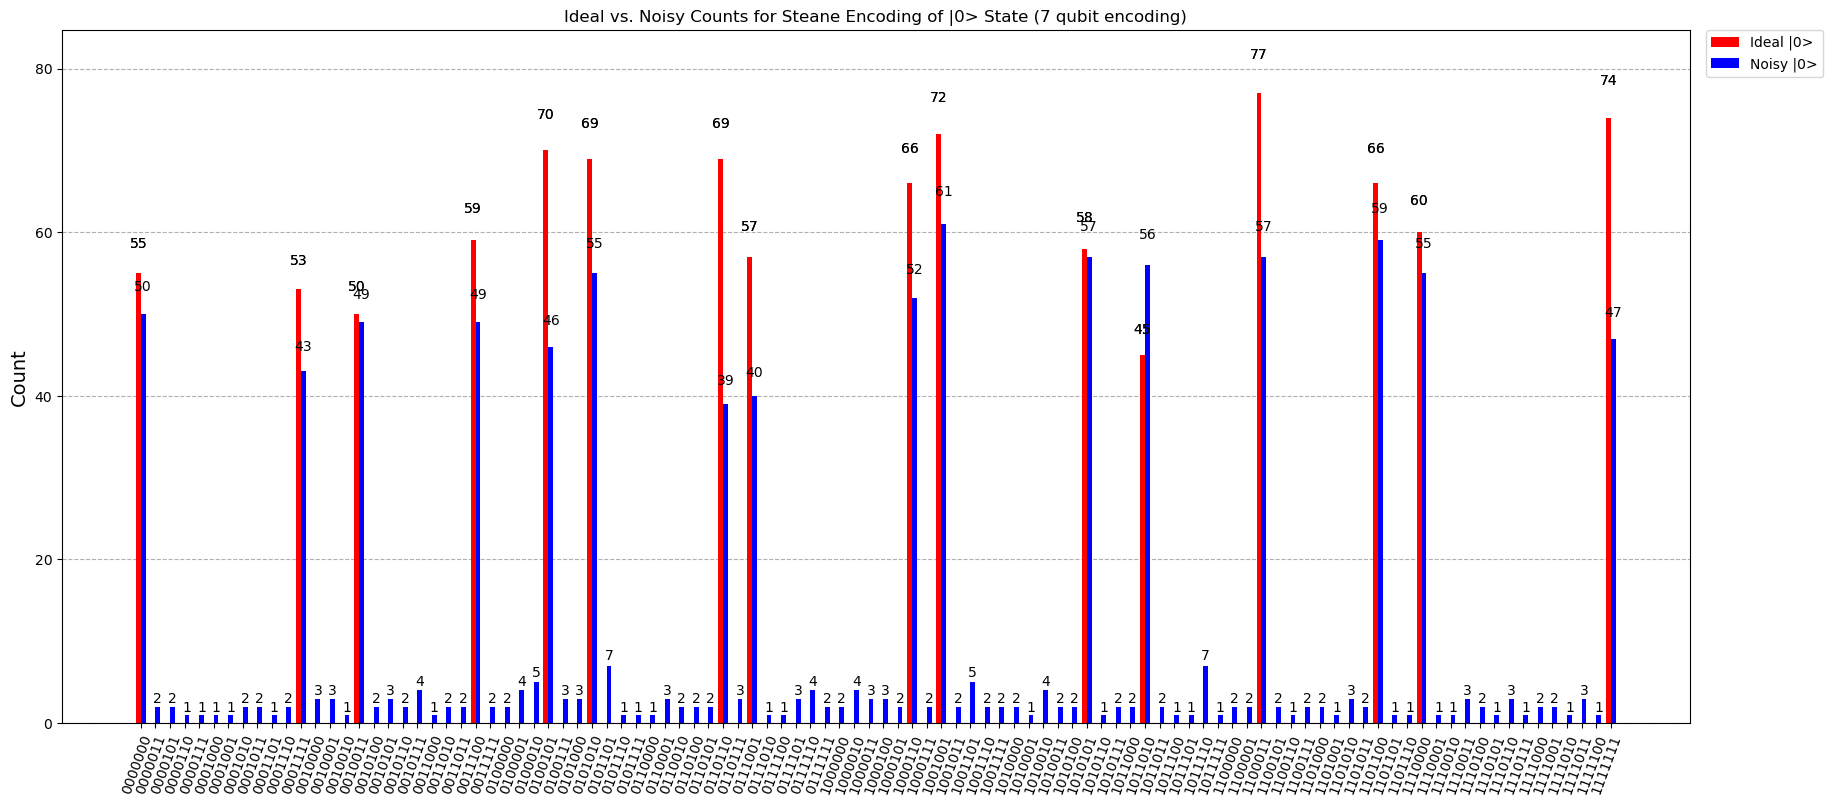

In [129]:
plot_histogram([counts_arr_meas_7[0], counts_arr_n_7[0]], 
               figsize = (21, 9), 
               title = "Ideal vs. Noisy Counts for Steane Encoding of |0> State (7 qubit encoding)", 
               bar_labels = True, 
               legend=['Ideal |0>', 'Noisy |0>'],
               color = ["red", "blue"])

# Testing Theta state

Now we test the theta state! We should obtain a similar fidelity

In [130]:

theta = np.arctan(np.sqrt((np.sqrt(5) - 1) / 2))
amp_0_theta = np.cos(theta/2)
amp_1_theta = np.sin(theta/2)

print(Statevector([amp_0_theta, amp_1_theta]))

steane_intr_theta_ideal = steane_enc_8(amp_0_theta, amp_1_theta, True)
steane_intr_theta_ideal_7 = steane_enc_7(amp_0_theta, amp_1_theta, True)

Statevector([0.94502682+0.j, 0.32699283+0.j],
            dims=(2,))


In [131]:

qc_arr_theta_n = []


[qc_arr_theta_n, state_arr_theta_n, counts_arr_theta_n] = preparation_results(qc_arr_n, 8, False, True, steane_block_instr_noise, noise_model)

qc_arr_n_theta_7 = []

[qc_arr_n_theta_7, state_arr_theta_n_7, counts_arr_theta_n_7] = preparation_results(qc_arr_n_7, 7, False, True, steane_block_instr_7_noise, noise_model)

    



In [132]:

qc_arr_theta_sv = []

[qc_arr_theta_sv, state_arr_theta_sv, counts_arr_theta_sv] = preparation_results(qc_arr_theta_sv, 8, True, False, steane_block_instr, no_noise)

qc_arr_theta_sv_7 = []

[qc_arr_theta_sv_7, state_arr_theta_sv_7, counts_arr_theta_sv_7] = preparation_results(qc_arr_theta_sv_7, 7, True, False, steane_block_instr_7, no_noise)


In [133]:

qc_arr_theta = []

[qc_arr_theta, state_arr_theta_ideal, counts_arr_theta_ideal] = preparation_results(qc_arr_theta, 8, True, True, steane_block_instr, no_noise)

qc_arr_theta_7 = []

[qc_arr_theta_7, state_arr_theta_ideal_7, counts_arr_theta_ideal_7] = preparation_results(qc_arr_n_7, 7, True, True, steane_block_instr_7, no_noise)

In [134]:
sv_theta = Statevector([amp_0_theta, amp_1_theta])
print(sv_theta)
print(state_arr_theta_sv)

[err_8_arr, fid_8_arr, err_8_mean, fid_8_mean] = raw_v_enc(sv_theta, state_arr_theta_sv)
[err_7_arr, fid_7_arr, err_7_mean, fid_7_mean]  = raw_v_enc(sv_theta, state_arr_theta_sv_7)

print(err_8_mean)
print(err_7_mean)

Statevector([0.94502682+0.j, 0.32699283+0.j],
            dims=(2,))
[Statevector([ 1.25000000e-01-4.5924255e-17j,
             -4.48005088e-18+1.5308085e-17j,
              1.08056541e-33+1.5308085e-17j,
             -4.48005088e-18+1.5308085e-17j,
              1.08056541e-33+1.5308085e-17j,
             -4.48005088e-18+1.5308085e-17j,
              1.25000000e-01-4.5924255e-17j,
             -4.48005088e-18+1.5308085e-17j,
             -4.48005088e-18+1.5308085e-17j,
              1.25000000e-01-4.5924255e-17j,
             -4.48005088e-18+1.5308085e-17j,
              1.08056541e-33+1.5308085e-17j,
             -4.48005088e-18+1.5308085e-17j,
              1.08056541e-33+1.5308085e-17j,
             -4.48005088e-18+1.5308085e-17j,
              1.25000000e-01-4.5924255e-17j,
             -4.48005088e-18+1.5308085e-17j,
              1.08056541e-33+1.5308085e-17j,
             -4.48005088e-18+1.5308085e-17j,
              1.25000000e-01-4.5924255e-17j,
             -4.48005088e-18+1

C:\Users\diyan\AppData\Local\Temp\ipykernel_25148\247150886.py:6: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  for z in state_arr_sv[0]:


Text(0.5, 1.0, 'Fidelity Errors Preparing |0> State in the Steane Code')

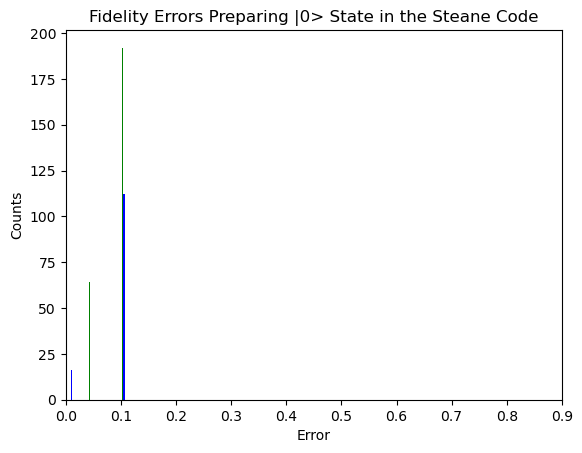

In [135]:
plt.hist([err_8_arr, err_7_arr], bins = 20, color= ['green', 'blue'])
plt.xlim(0,0.9)
plt.xlabel("Error")
plt.ylabel("Counts")
plt.title("Fidelity Errors Preparing |0> State in the Steane Code")

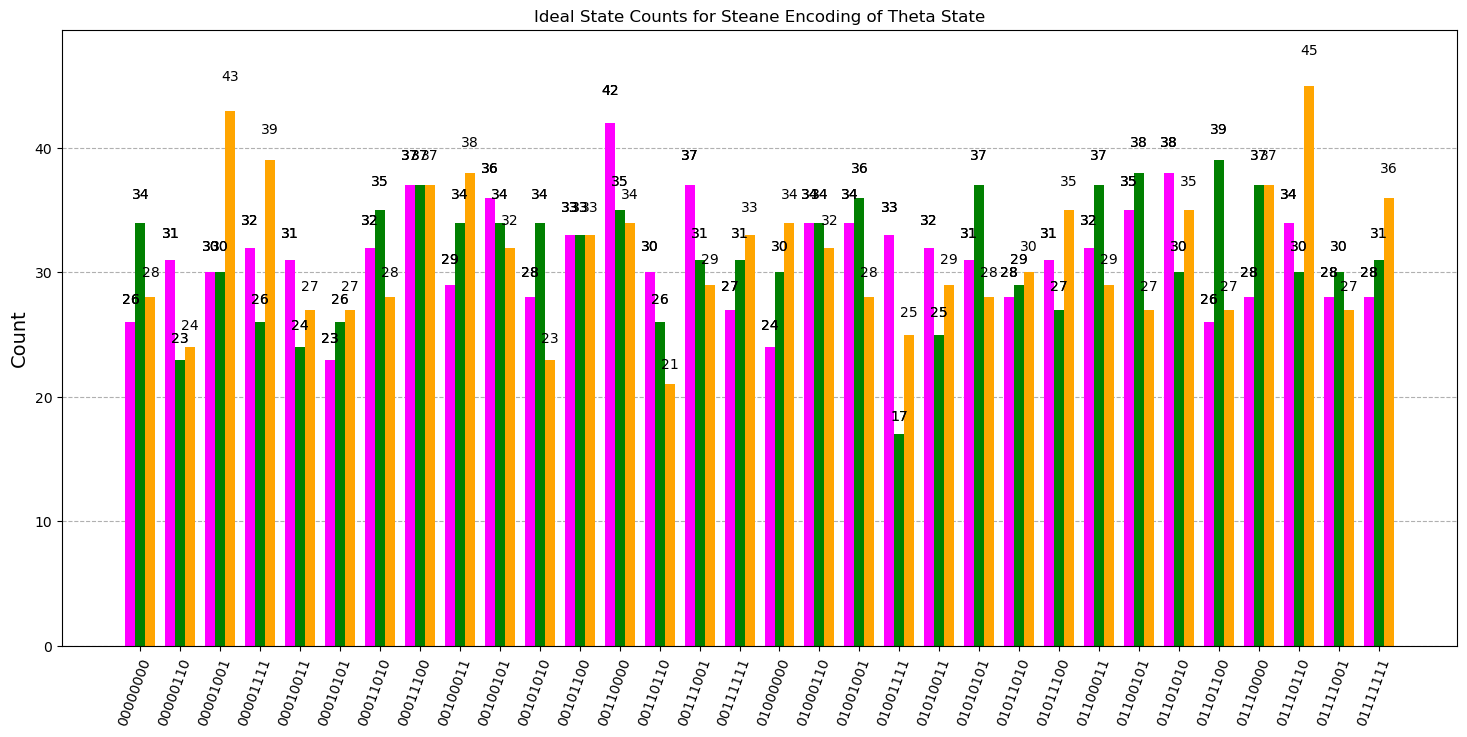

In [136]:
plot_histogram(counts_arr_theta_ideal, 
               figsize = (18, 8), 
               title = "Ideal State Counts for Steane Encoding of Theta State",
               color = ["magenta", "green", "orange"])

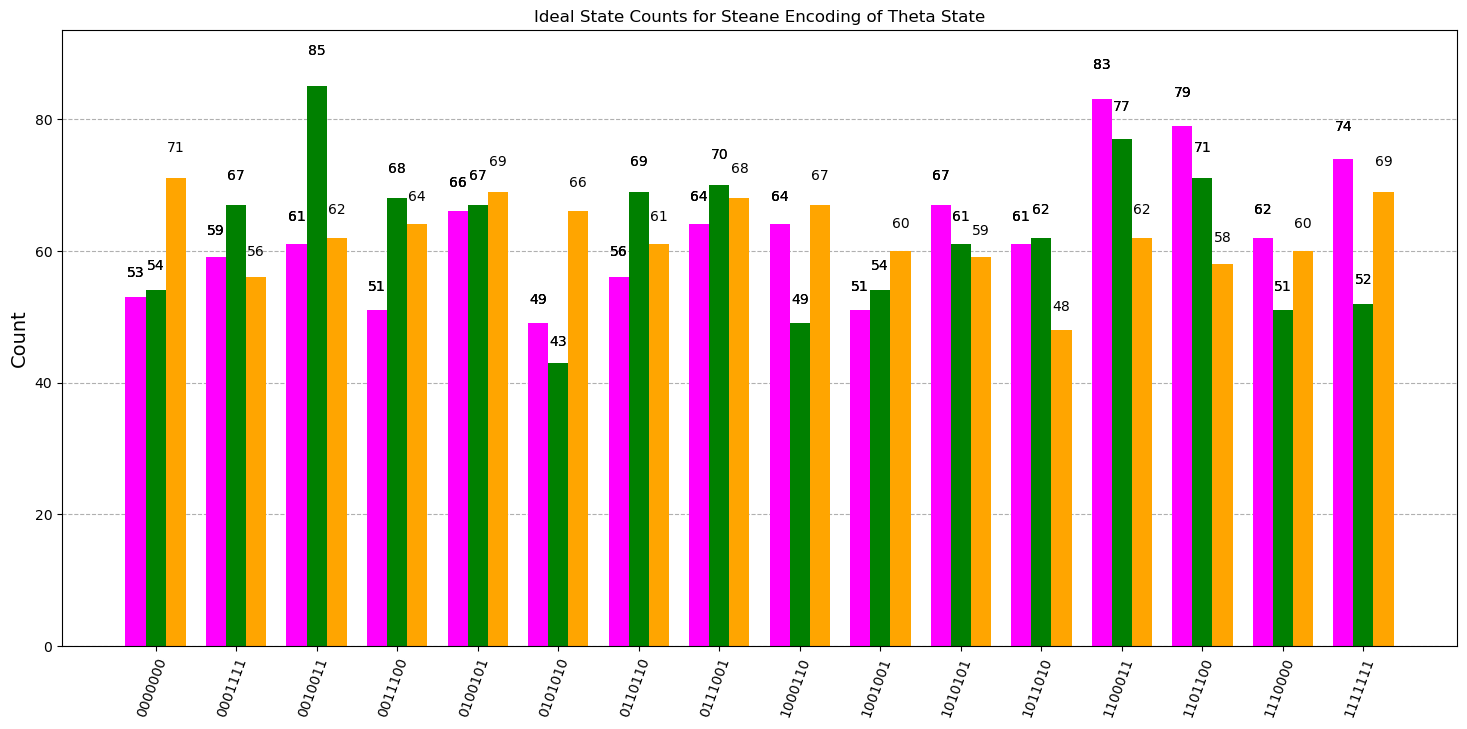

In [137]:
plot_histogram(counts_arr_theta_ideal_7, 
               figsize = (18, 8), 
               title = "Ideal State Counts for Steane Encoding of Theta State",
               color = ["magenta", "green", "orange"])

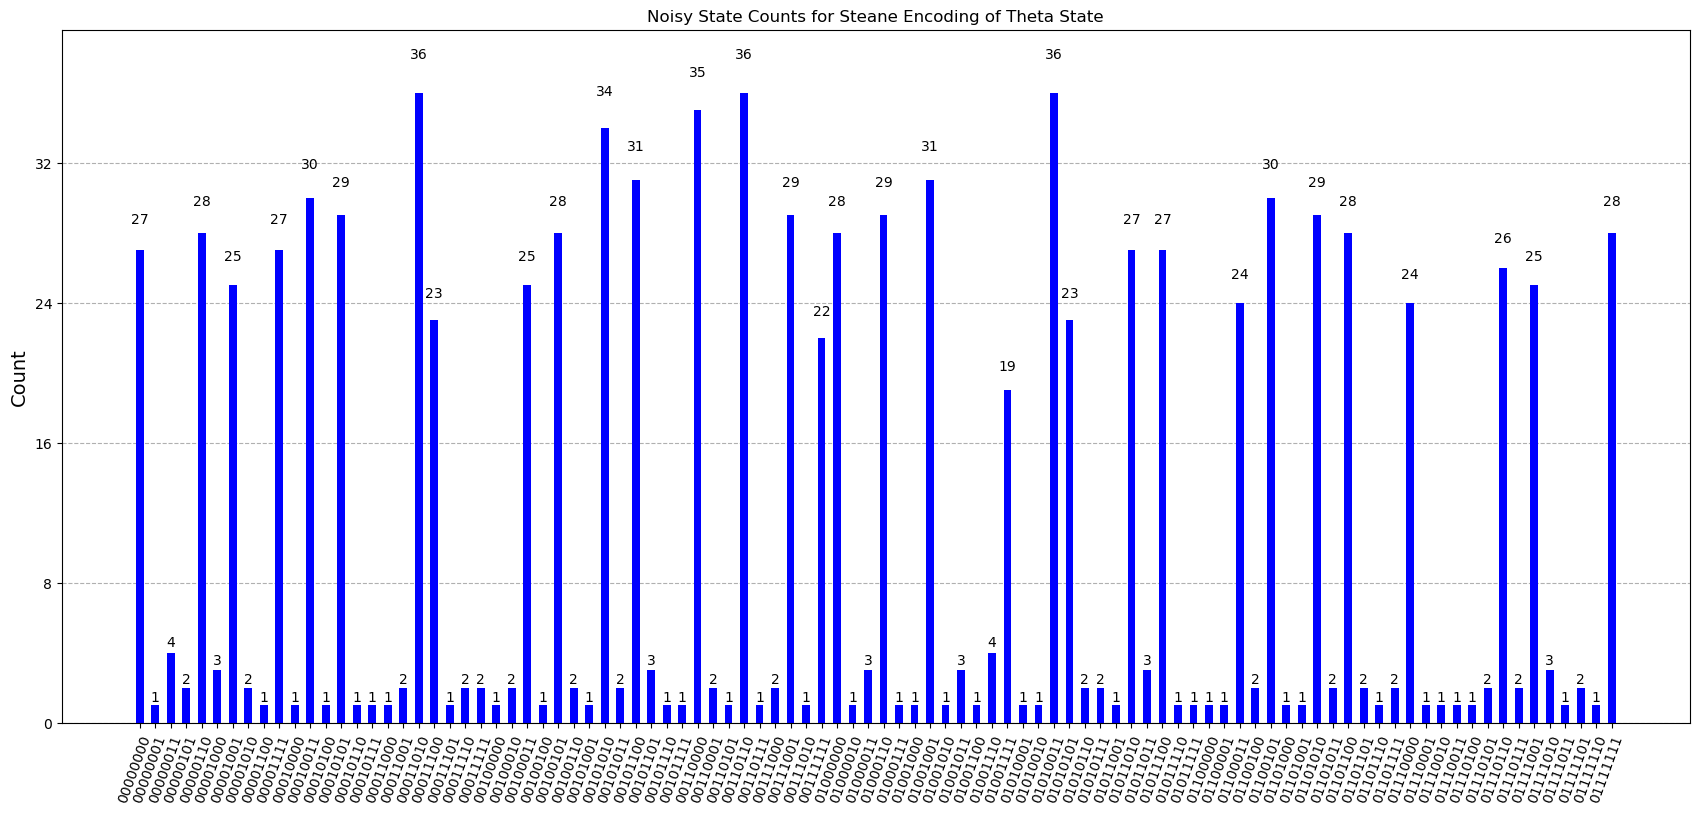

In [138]:
plot_histogram(counts_arr_theta_n[0], 
               figsize = (21, 9), 
               title = "Noisy State Counts for Steane Encoding of Theta State", 
               bar_labels = True,
               color = "blue")

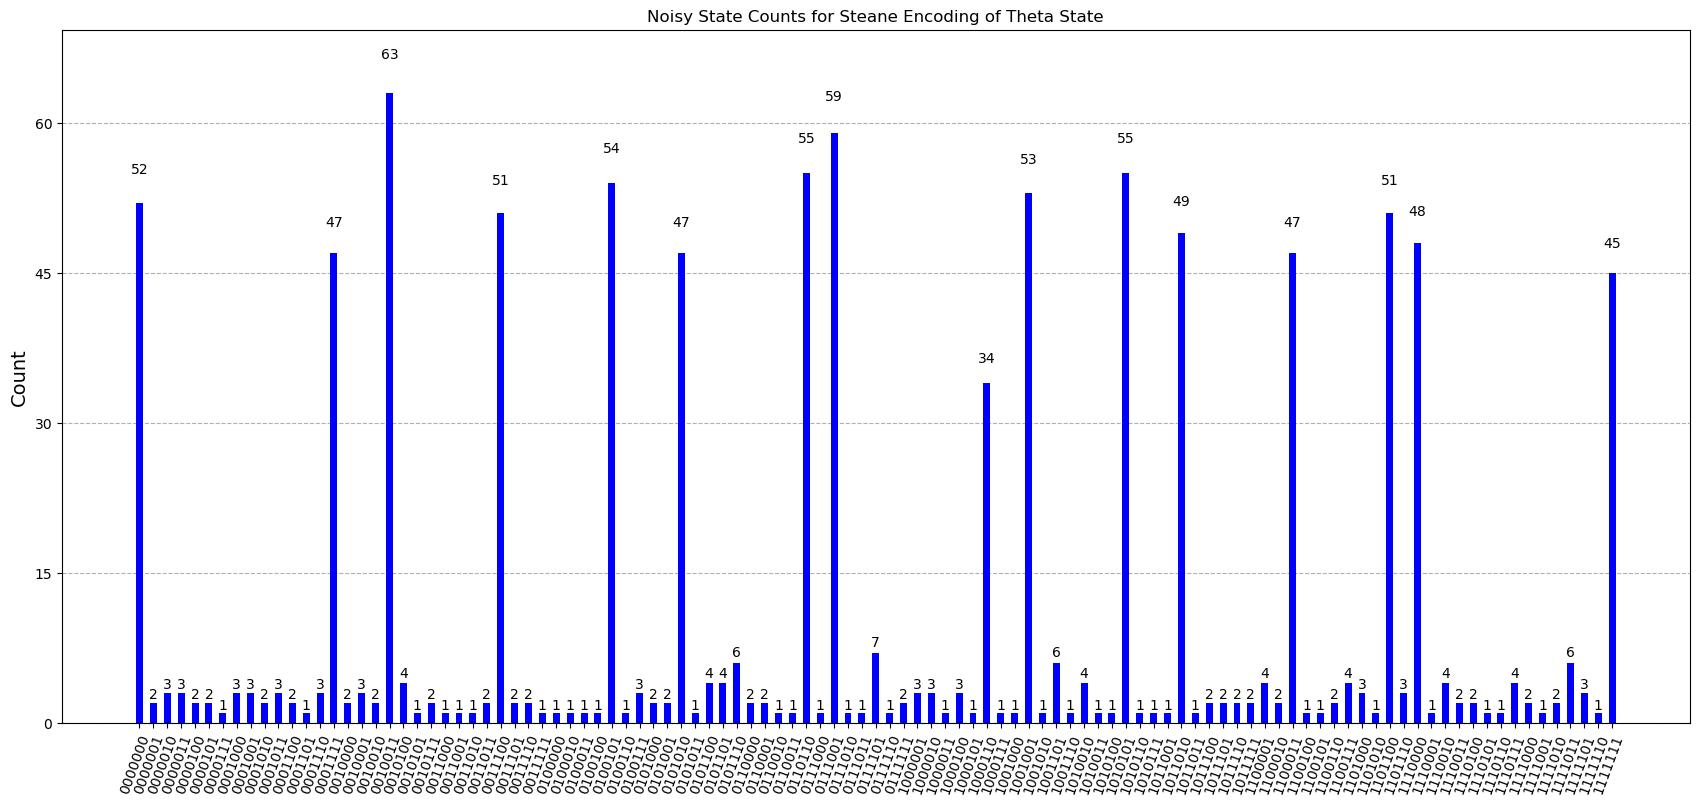

In [139]:
plot_histogram(counts_arr_theta_n_7[0], 
               figsize = (21, 9), 
               title = "Noisy State Counts for Steane Encoding of Theta State", 
               bar_labels = True,
               color = "blue")

## Fidelity of Theta State

In [140]:
mean_arr_theta_fid = []
err_arr_theta = []
for i in range(0,3):
    ffc = fidelity_from_counts(counts_arr_theta_ideal[i], counts_arr_theta_n[i])
    mean_arr_theta_fid.append(ffc)
    err_arr_theta.append(1 - ffc)



print(mean_arr_theta_fid)
print(np.mean(mean_arr_theta_fid))

[0.8917484818147992, 0.8730370845507349, 0.8856654029618705]
0.8834836564424681


In [141]:
mean_arr_theta_fid = []
err_arr_theta = []
for i in range(0,3):
    ffc = fidelity_from_counts(counts_arr_theta_ideal_7[i], counts_arr_theta_n_7[i])
    mean_arr_theta_fid.append(ffc)
    err_arr_theta.append(1 - ffc)



print(mean_arr_theta_fid)
print(np.mean(mean_arr_theta_fid))

[0.8010067328874451, 0.7971638969220243, 0.8164561349633782]
0.8048755882576158


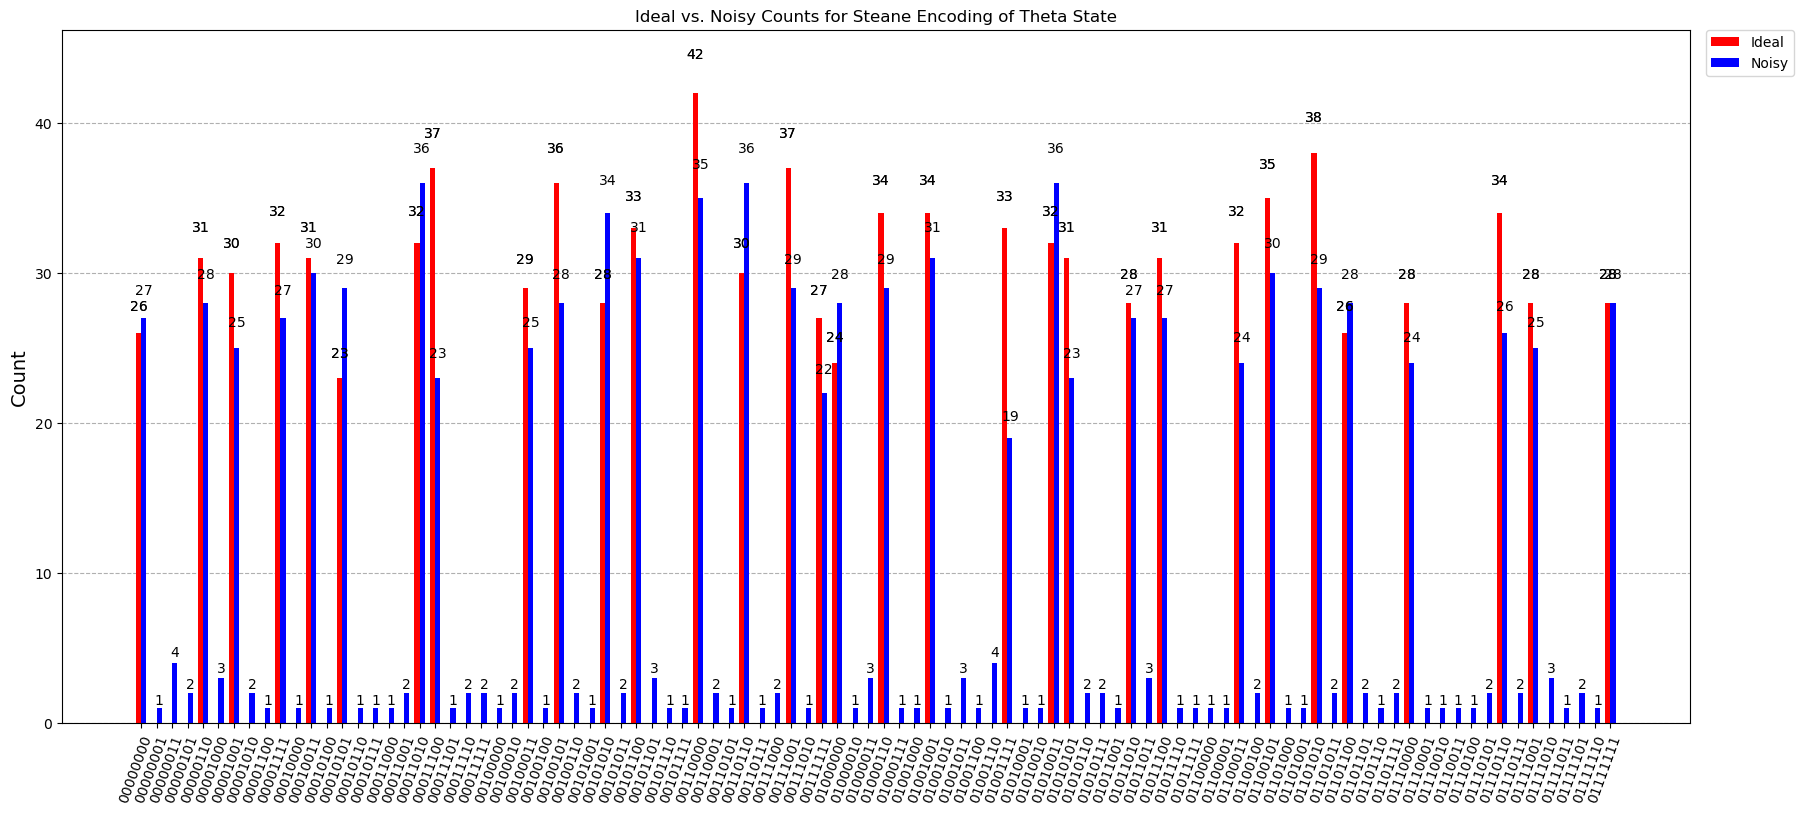

In [142]:
plot_histogram([counts_arr_theta_ideal[0], counts_arr_theta_n[0]], 
               figsize = (21, 9), 
               title = "Ideal vs. Noisy Counts for Steane Encoding of Theta State", 
               bar_labels = True, 
               legend=['Ideal', 'Noisy'],
               color = ["red", "blue"])



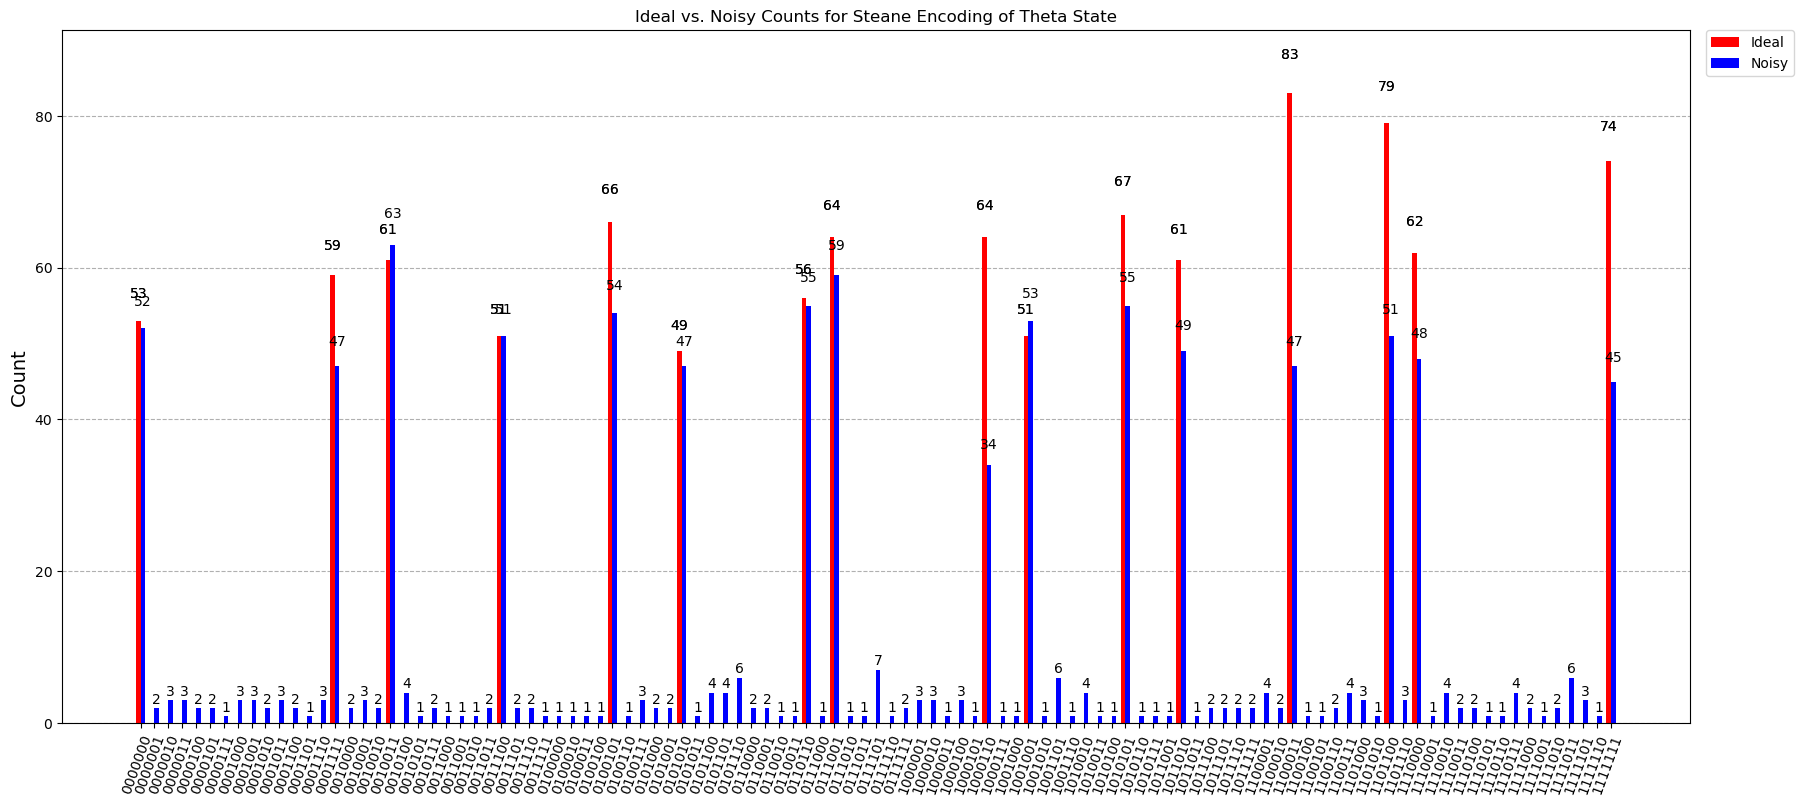

In [143]:
plot_histogram([counts_arr_theta_ideal_7[0], counts_arr_theta_n_7[0]], 
               figsize = (21, 9), 
               title = "Ideal vs. Noisy Counts for Steane Encoding of Theta State", 
               bar_labels = True, 
               legend=['Ideal', 'Noisy'],
               color = ["red", "blue"])